In [69]:
from SDP_interaction_inference.constraints import Constraint
from SDP_interaction_inference import optimization
from SDP_interaction_inference.dataset import Dataset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import plotly
import plotly.graph_objects as go

In [2]:
# read fibroblast transcript counts (for genes with mean expression > 1)
data_FIB = pd.read_csv("../../Real-Data/Datasets/GSE151334_FIB_counts_thresh.csv", index_col=0)

# read RNA types in from file
biotypes_dict = json.load(open("../../Real-Data/Datasets/GSE151334_RNA_types_thresh.json"))
biotypes_dict = {int(i): btype for i, btype in biotypes_dict.items()}
biotypes = [btype for btype in biotypes_dict.values()]

# select indices of types
pcRNA_indices = [idx for idx, val in enumerate(biotypes) if val == "protein_coding"]
miRNA_indices = [idx for idx, val in enumerate(biotypes) if val == "miRNA"]

# select rows by index
data_pcRNA = data_FIB.iloc[pcRNA_indices]
data_miRNA = data_FIB.iloc[miRNA_indices]

# amounts
print(f"{data_FIB.shape[0]} genes with mean > 1 \n{data_miRNA.shape[0]} miRNA \n{data_pcRNA.shape[0]} protein coding mRNA")

11901 genes with mean > 1 
18 miRNA 
9376 protein coding mRNA


In [3]:
def estimate_capture(df, beta_mean=0.1):

    # set mean beta
    MeanBETA = beta_mean

    #xx<-Matrix::colSums(Data)
    xx = df.sum(axis='rows')

    #Normcount <- t_sp(t_sp(Data)/xx) * mean(xx)
    # Normcount <- Matrix::t(Matrix::t(Data)/xx) * mean(xx)
    Normcount = (df / xx) * np.mean(xx) # sum = mean(xx) per column

    #means <- Matrix::rowMeans(Normcount)
    means = Normcount.mean(axis='columns')

    #lmeans <- log(means)
    lmean = np.log(means)

    #med <- apply(log(Normcount + 1), 1, function(x) {
    #    median(x)
    #})
    med = np.log(Normcount + 1).median(axis=1)

    #mad <- apply(log(Normcount + 1), 1, function(x) {
    #    mad(x)
    #})
    mad = np.log(Normcount + 1).apply(lambda row: (row - row.median()).abs().median(), axis=1)

    #bound <- med + 3 * mad
    bound = med + 3*mad

    #maxlogGene <- apply(log(Normcount + 1), 1, max)
    maxlogGene = np.log(Normcount + 1).max(axis=1)

    #ind <- which(maxlogGene < bound)
    ind = maxlogGene < bound

    #dropout = apply(Data, 1, function(x) {
    #    length(which(x == 0))/length(x)
    #})
    dropout = df.apply(lambda row: (row == 0).sum() / row.size, axis=1)


    #Select_ind <- intersect(ind, which(dropout < 0.35))
    Select_ind = ind & (dropout < 0.35)

    # Selected_genes <- rownames(Data)[Select_ind]
    Selected_genes = list(Select_ind.index)

    #temppp <- Matrix::colSums(Data[Select_ind, ])
    temppp = df[Select_ind].sum(axis=0)

    #BETA <- temppp/mean(temppp) * MeanBETA
    BETA = (temppp / temppp.mean()) * MeanBETA

    #if (length(which(BETA >= 1)) > 0) {
    #    BETA[BETA >= 1] = max(BETA[BETA < 1])
    #}
    #if (length(which(BETA <= 0)) > 0) {
    #    BETA[BETA <= 0] = min(BETA[BETA > 0])
    #}
    if (BETA >= 1).size > 0:
        BETA[BETA >= 1] = BETA[BETA < 1].max()
    if (BETA <= 0).size > 0:
        BETA[BETA <= 0] = BETA[BETA > 0].min()

    #names(BETA) <- colnames(Data)

    #return(list(BETA = BETA, Selected_genes = Selected_genes))
    BETA = BETA.to_numpy()
    
    return BETA

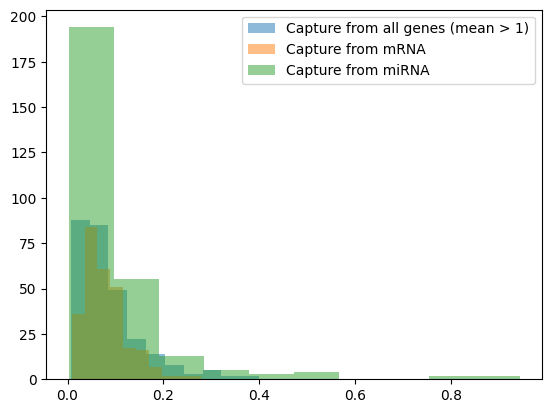

In [4]:
beta = estimate_capture(data_FIB)
beta_m = estimate_capture(data_pcRNA)
beta_mi = estimate_capture(data_miRNA)
plt.hist(beta, alpha=0.5, label="Capture from all genes (mean > 1)")
plt.hist(beta_m, alpha=0.5, label="Capture from mRNA")
plt.hist(beta_mi, alpha=0.5, label="Capture from miRNA")
plt.legend()
plt.show()

In [5]:
def construct_dataset(mirna_sample, mrna_dataset, beta, resamples=1000):

    # size
    gene_pairs, cells = mrna_dataset.shape

    # construct paired count dataframe
    counts_df = pd.DataFrame(
        index = [f"Gene-pair-{i}" for i in range(gene_pairs)],
        columns = [f"Cell-{j}" for j in range(cells)]
    )

    # fill with pairs
    for i in range(gene_pairs):
        gene_i = mirna_sample
        gene_j = mrna_dataset.iloc[i]
        gene_pair_ij = list(zip(gene_i, gene_j))
        counts_df.iloc[i] = gene_pair_ij

    # construct dataset object
    data = Dataset()
    data.count_dataset = counts_df
    data.cells = cells
    data.gene_pairs = gene_pairs

    # settings
    data.resamples = resamples

    # set capture
    data.beta = beta

    return data

In [6]:
def reduce_dataset(dataset, selected_indices):

    # size
    cells = dataset.cells
    gene_pairs = len(selected_indices)

    # construct paired count dataframe
    counts_df = pd.DataFrame(
        index = [f"Gene-pair-{i}" for i in range(gene_pairs)],
        columns = [f"Cell-{j}" for j in range(cells)]
    )

    # construct moment bounds dict
    moment_dict = {}

    # copy over selected data
    for i, j in enumerate(selected_indices):
        counts_df.iloc[i] = dataset.count_dataset.iloc[j]
        moment_dict[f'sample-{i}'] = dataset.moment_bounds[f'sample-{j}']

    # construct dataset object
    data = Dataset()
    data.count_dataset = counts_df
    data.cells = cells
    data.gene_pairs = gene_pairs

    # settings
    data.resamples = dataset.resamples

    # set capture
    data.beta = dataset.beta

    # set moments
    data.moment_bounds = moment_dict
    data.d = dataset.d

    return data

In [7]:
def sankey_from_df(df):

    column_number = df.shape[1]

    # unique values per column
    column_values = []

    # box indices per column
    column_indices = []

    i = 1
    for col in df.columns:

        values = df[col].unique().tolist()
        column_values.append(values)

        boxes = len(values)
        indices = [x for x in range(i, i + boxes)]
        column_indices.append(indices)

        i += boxes

    # plotting
    source = []
    target = []
    count = []

    # special case for first gap

    # end values
    val_end = column_values[0]

    # end indices
    idx_end = column_indices[0]

    # end column
    col_end = df[df.columns[0]]

    # for each end value
    for val_k, idx_k in zip(val_end, idx_end):

        # get count
        count_k = len(df.loc[col_end == val_k])

        # add link to plot: from 0 to idx with size count
        source.append(0)
        target.append(idx_k)
        count.append(count_k)

    for i in range(column_number - 1):

        # get values
        val_start = column_values[i]
        val_end = column_values[i + 1]

        # get indices
        idx_start = column_indices[i]
        idx_end = column_indices[i + 1]

        # get columns
        col_start = df[df.columns[i]]
        col_end = df[df.columns[i + 1]]

        # for each pair of values level
        for val_j, idx_j in zip(val_start, idx_start):
            for val_k, idx_k in zip(val_end, idx_end):

                # get overlap
                count_jk = len(df.loc[(col_start == val_j) & (col_end == val_k)])

                # add link to plot: from idx_j to idx_k with size count_jk
                source.append(idx_j)
                target.append(idx_k)
                count.append(count_jk)

    # box labels
    labels = [""]
    for values in column_values:
        for val in values:
            labels.append(str(val))

    fig = go.Figure(data=[go.Sankey(
        node = {"label": labels},
        link = {"source": source, "target": target, "value": count, "color": "lightgrey"}
        )])

    headers = ["Gene pairs"] + list(df.columns)
    for x_coordinate, column_name in enumerate(headers):
        fig.add_annotation(
                x=x_coordinate / (column_number),
                y=1.1,
                xref="paper",
                yref="paper",
                text=column_name,
                showarrow=False,
                font=dict(
                    family="Courier New, monospace",
                    size=16,
                    color="tomato"
                    ),
                align="center",
                )
        
    #fig.update_layout(font_size=15)
    fig.update_layout(
        title_text="Basic Sankey Diagram", 
        xaxis={
        'showgrid': False, # thin lines in the background
        'zeroline': False, # thick line at x=0
        'visible': False,  # numbers below
        },
        yaxis={
        'showgrid': False, # thin lines in the background
        'zeroline': False, # thick line at x=0
        'visible': False,  # numbers below
        }, plot_bgcolor='rgba(0,0,0,0)', font_size=10
    )

    fig.show()

In [8]:
def text_map_mf(text):
    if text == "INFEASIBLE":
        return "DEPENDENT"
    elif text == "OPTIMAL":
        return "INDEPENDENT"
    else:
        return text

def text_map(text):
    if text == "OPTIMAL":
        return "FEASIBLE"
    else:
        return text

In [9]:
def dataset_analysis(dataset, d):

    # bootstrap
    dataset.bootstrap(d=d, tqdm_disable=False)

    # Model free test
    constraints = Constraint(
        moment_bounds=True,
        moment_matrices=True,
        factorization=True
    )

    # test feasibility
    opt_MF = optimization.ModelFreeOptimization(dataset, d, constraints=constraints, printing=False, silent=True)
    opt_MF.analyse_dataset()

    # select indices
    selected_indices_mf_int = []
    selected_indices_mf_ind = []
    for i, mf_result in opt_MF.result_dict.items():
        if mf_result['status'] == "INFEASIBLE":
            selected_indices_mf_int.append(i)
        elif mf_result['status'] == "OPTIMAL":
            selected_indices_mf_ind.append(i)
    dataset_mf_int = reduce_dataset(dataset, selected_indices_mf_int)
    dataset_mf_ind = reduce_dataset(dataset, selected_indices_mf_ind)

    # --------------------------------------------------------------------------

    # Interacting Birth-Death
    constraints = Constraint(
        moment_bounds=True,
        moment_matrices=True,
        moment_equations=True,
        factorization=False
    )
    fixed = [(1, 1)]

    # test feasibility
    opt_BD_int = optimization.BirthDeathOptimization(dataset_mf_int, d, constraints=constraints, silent=True, fixed=fixed)
    opt_BD_int.analyse_dataset()

    # select indices
    selected_indices_bd_int = []
    for i, bd_result in opt_BD_int.result_dict.items():
        if bd_result['status'] == "INFEASIBLE":
            selected_indices_bd_int.append(i)
    dataset_bd_int = reduce_dataset(dataset_mf_int, selected_indices_bd_int)

    # Interacting Telegraph
    constraints = Constraint(
        moment_bounds=True,
        moment_matrices=True,
        moment_equations=True,
        telegraph_moments=True,
        telegraph_moments_ineq=True,
        telegraph_factorization=False
    )
    fixed = [(3, 1)]

    # test feasibility
    opt_TE_int = optimization.TelegraphOptimization(dataset_bd_int, d, constraints=constraints, silent=True, fixed=fixed)
    opt_TE_int.analyse_dataset()

    # --------------------------------------------------------------------------

    # Independent Birth-Death
    constraints = Constraint(
        moment_bounds=True,
        moment_matrices=True,
        moment_equations=True,
        factorization=True
    )
    fixed = [(1, 1), (3, 1), (4, 0)]

    # test feasibility
    opt_BD_ind = optimization.BirthDeathOptimization(dataset_mf_ind, d, constraints=constraints, silent=True, fixed=fixed)
    opt_BD_ind.analyse_dataset()

    # select indices
    selected_indices_bd_ind = []
    for i, bd_result in opt_BD_ind.result_dict.items():
        if bd_result['status'] == "INFEASIBLE":
            selected_indices_bd_ind.append(i)
    dataset_bd_ind = reduce_dataset(dataset_mf_ind, selected_indices_bd_ind)

    # Interacting Telegraph
    constraints = Constraint(
        moment_bounds=True,
        moment_matrices=True,
        moment_equations=True,
        telegraph_moments=True,
        telegraph_moments_ineq=True,
        telegraph_factorization=True
    )
    fixed = [(3, 1), (7, 1), (8, 0)]

    # test feasibility
    opt_TE_ind = optimization.TelegraphOptimization(dataset_bd_ind, d, constraints=constraints, silent=True, fixed=fixed)
    opt_TE_ind.analyse_dataset()

    # --------------------------------------------------------------------------

    # size
    genes = dataset.gene_pairs

    result_summary_int = pd.DataFrame(
        index=[f"Gene-pair-{i}" for i in range(genes)],
        columns=["Model free test", "Int. Birth-Death", "Int. Telegraph"]
    )

    time_summary_int = pd.DataFrame(
        index=[f"Gene-pair-{i}" for i in range(genes)],
        columns=["Model free test", "Int. Birth-Death", "Int. Telegraph"]
    )

    cuts_summary_int = pd.DataFrame(
        index=[f"Gene-pair-{i}" for i in range(genes)],
        columns=["Model free test", "Int. Birth-Death", "Int. Telegraph"]
    )

    for i, MF_result in opt_MF.result_dict.items():
        result_summary_int.iloc[i, 0] = text_map_mf(MF_result['status'])
        time_summary_int.iloc[i, 0] = MF_result['time']
        cuts_summary_int.iloc[i, 0] = MF_result['cuts']
    for i, BD_result in opt_BD_int.result_dict.items():
        j = selected_indices_mf_int[i]
        result_summary_int.iloc[j, 1] = text_map(BD_result['status'])
        time_summary_int.iloc[j, 1] = BD_result['time']
        cuts_summary_int.iloc[j, 1] = BD_result['cuts']
    for i, TE_result in opt_TE_int.result_dict.items():
        j = selected_indices_bd_int[i]
        k = selected_indices_mf_int[j]
        result_summary_int.iloc[k, 2] = text_map(TE_result['status'])
        time_summary_int.iloc[k, 2] = TE_result['time']
        cuts_summary_int.iloc[k, 2] = TE_result['cuts']

    # --------------------------------------------------------------------------
    # Ideally combine ind + int BUT Sankey plot tricky to do
    # --------------------------------------------------------------------------
    
    result_summary_ind = pd.DataFrame(
        index=[f"Gene-pair-{i}" for i in range(genes)],
        columns=["Model free test", "Ind. Birth-Death", "Ind. Telegraph"]
    )

    time_summary_ind = pd.DataFrame(
        index=[f"Gene-pair-{i}" for i in range(genes)],
        columns=["Model free test", "Ind. Birth-Death", "Ind. Telegraph"]
    )

    cuts_summary_ind = pd.DataFrame(
        index=[f"Gene-pair-{i}" for i in range(genes)],
        columns=["Model free test", "Ind. Birth-Death", "Ind. Telegraph"]
    )

    for i, MF_result in opt_MF.result_dict.items():
        result_summary_ind.iloc[i, 0] = text_map_mf(MF_result['status'])
        time_summary_ind.iloc[i, 0] = MF_result['time']
        cuts_summary_ind.iloc[i, 0] = MF_result['cuts']
    for i, BD_result in opt_BD_ind.result_dict.items():
        j = selected_indices_mf_ind[i]
        result_summary_ind.iloc[j, 1] = text_map(BD_result['status'])
        time_summary_ind.iloc[j, 1] = BD_result['time']
        cuts_summary_ind.iloc[j, 1] = BD_result['cuts']
    for i, TE_result in opt_TE_ind.result_dict.items():
        j = selected_indices_bd_ind[i]
        k = selected_indices_mf_ind[j]
        result_summary_ind.iloc[k, 2] = text_map(TE_result['status'])
        time_summary_ind.iloc[k, 2] = TE_result['time']
        cuts_summary_ind.iloc[k, 2] = TE_result['cuts']

    # --------------------------------------------------------------------------

    data_dict = {
        'result_summary_int': result_summary_int,
        'time_summary_int': time_summary_int,
        'cuts_summary_int': cuts_summary_int,
        'result_summary_ind': result_summary_ind,
        'time_summary_ind': time_summary_ind,
        'cuts_summary_ind': cuts_summary_ind
    }

    return data_dict

# Different miRNA

In [10]:
data_miRNA.index

Index(['MIR100', 'MIR103A2', 'MIR16-2', 'MIR199A1', 'MIR199A2', 'MIR221',
       'MIR222', 'MIR23A', 'MIR24-2', 'MIR27A', 'MIR29A', 'MIR31', 'MIR3609',
       'MIR4449', 'MIR877', 'MIRLET7A1', 'MIRLET7A2', 'MIRLET7D'],
      dtype='object')

In [32]:
# genes
genes = 100
k = 0

# construct dataset of the miRNA paired with mRNA (NOTE: not actually using target scan targets)
dataset_mir = construct_dataset(data_miRNA.loc["MIR100"], data_pcRNA[k:k+genes], beta)

# order
d = 3

# run
results = dataset_analysis(dataset_mir, d)

100%|██████████| 80/80 [00:22<00:00,  3.60it/s]


In [33]:
sankey_from_df(results['result_summary_int'])
sankey_from_df(results['result_summary_ind'])

In [25]:
# genes
genes = 100
k = 0

# construct dataset of the miRNA paired with mRNA (NOTE: not actually using target scan targets)
dataset_mir = construct_dataset(data_miRNA.loc["MIR103A2"], data_pcRNA[k:k+genes], beta)

# order
d = 3

# run
results = dataset_analysis(dataset_mir, d)

100%|██████████| 70/70 [00:22<00:00,  3.08it/s]


In [26]:
sankey_from_df(results['result_summary_int'])
sankey_from_df(results['result_summary_ind'])

In [34]:
# genes
genes = 100
k = 0

# construct dataset of the miRNA paired with mRNA (NOTE: not actually using target scan targets)
dataset_mir = construct_dataset(data_miRNA.loc["MIR16-2"], data_pcRNA[k:k+genes], beta)

# order
d = 3

# run
results = dataset_analysis(dataset_mir, d)

100%|██████████| 93/93 [00:23<00:00,  3.92it/s]


In [35]:
sankey_from_df(results['result_summary_int'])
sankey_from_df(results['result_summary_ind'])

# Different capture

In [9]:
# mean capture values
mean_list = [0.1, 0.25, 0.5, 0.75, 1.0]

# capture vectors
beta_list = []
for m in mean_list:
    beta_m = estimate_capture(data_FIB, beta_mean=m)
    beta_list.append(beta_m)

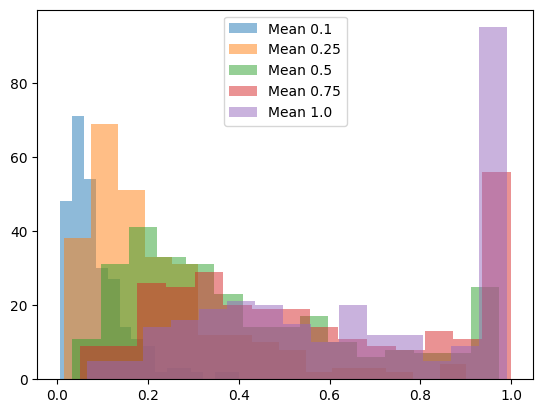

In [10]:
for i, beta_m in enumerate(beta_list):
    plt.hist(beta_m, alpha=0.5, bins=15, label=f"Mean {mean_list[i]}")
plt.legend()
plt.show()

In [11]:
# genes
genes = 100
k = 0

# for each beta m value create dataset and run analysis
results_list = []
for i, beta_m in enumerate(beta_list):

    # construct dataset of the miRNA paired with mRNA (NOTE: not actually using target scan targets)
    dataset_mir = construct_dataset(data_miRNA.loc["MIR103A2"], data_pcRNA[k:k+genes], beta_m)

    # order
    d = 3

    # run
    results = dataset_analysis(dataset_mir, d)

    # store
    results_list.append(results)

100%|██████████| 23/23 [00:01<00:00, 14.08it/s]
0it [00:00, ?it/s]
100%|██████████| 22/22 [00:01<00:00, 13.22it/s]
0it [00:00, ?it/s]
100%|██████████| 20/20 [00:01<00:00, 13.61it/s]
0it [00:00, ?it/s]
100%|██████████| 80/80 [01:16<00:00,  1.04it/s]


In [17]:
for result in results_list:
    sankey_from_df(result['result_summary_int'])
    sankey_from_df(result['result_summary_ind'])

### Results

When increasing the mean capture
- Model free: dependent pairs slightly decreased (in general)
- Int BD: all inf -> mix -> all feasible
- Int TE: all feasible
- Ind BD: all infeasible
- Ind TE: mostly inf -> mix -> almost all feasible

Overall all models give more feasible results as mean capture increases
- assuming a weaker downsampling effect means observed data adjusted less??


In [15]:
# genes
genes = 100
k = 0

# for each beta m value create dataset and run analysis
results_list_fixed = []
for i, mean in enumerate(mean_list):

    # fixed capture
    beta_m = np.array([mean for i in range(data_FIB.shape[1])])

    # construct dataset of the miRNA paired with mRNA (NOTE: not actually using target scan targets)
    dataset_mir = construct_dataset(data_miRNA.loc["MIR103A2"], data_pcRNA[k:k+genes], beta_m)

    # order
    d = 3

    # run
    results = dataset_analysis(dataset_mir, d)

    # store
    results_list_fixed.append(results)

100%|██████████| 16/16 [00:00<00:00, 17.38it/s]
0it [00:00, ?it/s]
100%|██████████| 16/16 [00:00<00:00, 18.31it/s]
0it [00:00, ?it/s]
100%|██████████| 83/83 [01:34<00:00,  1.13s/it]


In [18]:
for result in results_list_fixed:
    sankey_from_df(result['result_summary_int'])
    sankey_from_df(result['result_summary_ind'])

### Results

- Constant capture over cells
    - model free dependent pair # reduced
- Increasing constant
    - model free results dont change
    - other models sig change after first increase then roughly constant

# Correlation

In [14]:
from SDP_interaction_inference.correlation import Correlation

In [21]:
def correlation_analysis(dataset):

    # run
    correlation = Correlation(dataset, printing=False)

    # store
    result_summary_corr = pd.DataFrame(
        index=[f"Gene-pair-{i}" for i in range(genes)],
        columns=["Correlation"]
    )

    value_summary_corr = pd.DataFrame(
        index=[f"Gene-pair-{i}" for i in range(genes)],
        columns=["Statistic", "pvalue"]
    )

    for i, C_result in correlation.result_dict.items():
        if C_result['pvalue'] < 0.05:
            result_summary_corr.iloc[i] = "DEPENDENT"
        else:
            result_summary_corr.iloc[i] = "INDEPENDENT"
        value_summary_corr.iloc[i, 0] = C_result['statistic']
        value_summary_corr.iloc[i, 1] = C_result['pvalue']

    data_dict ={
        'result_summary_corr': result_summary_corr,
        'value_summary_corr': value_summary_corr
    }

    return data_dict

In [ ]:
corr_list = []

for miRNA in data_miRNA.index:
    
    # genes
    genes = 10000
    k = 0

    # construct dataset of the miRNA paired with mRNA (NOTE: not actually using target scan targets)
    dataset_mir = construct_dataset(data_miRNA.loc[miRNA], data_pcRNA[k:k+genes], beta)

    # run
    results_corr = correlation_analysis(dataset_mir)

    # store
    corr_list.append(results_corr)

100%|██████████| 9376/9376 [00:15<00:00, 590.04it/s]


In [ ]:
for i, result in enumerate(corr_list):
    name = data_miRNA.index[i]
    num = int((result['result_summary_corr'] == "DEPENDENT").sum().iloc[0])
    print(f"{num} / 9376 ({name}, mRNA) pairs have sig. negative correlation")

0 / 9376 (MIR100, mRNA) pairs have sig. negative correlation
7 / 9376 (MIR103A2, mRNA) pairs have sig. negative correlation
6 / 9376 (MIR16-2, mRNA) pairs have sig. negative correlation
0 / 9376 (MIR199A1, mRNA) pairs have sig. negative correlation
2 / 9376 (MIR199A2, mRNA) pairs have sig. negative correlation
2 / 9376 (MIR221, mRNA) pairs have sig. negative correlation
3 / 9376 (MIR222, mRNA) pairs have sig. negative correlation
0 / 9376 (MIR23A, mRNA) pairs have sig. negative correlation
4 / 9376 (MIR24-2, mRNA) pairs have sig. negative correlation
2 / 9376 (MIR27A, mRNA) pairs have sig. negative correlation
8 / 9376 (MIR29A, mRNA) pairs have sig. negative correlation
2 / 9376 (MIR31, mRNA) pairs have sig. negative correlation
3 / 9376 (MIR3609, mRNA) pairs have sig. negative correlation
1 / 9376 (MIR4449, mRNA) pairs have sig. negative correlation
12 / 9376 (MIR877, mRNA) pairs have sig. negative correlation
2 / 9376 (MIRLET7A1, mRNA) pairs have sig. negative correlation
3 / 9376 (M

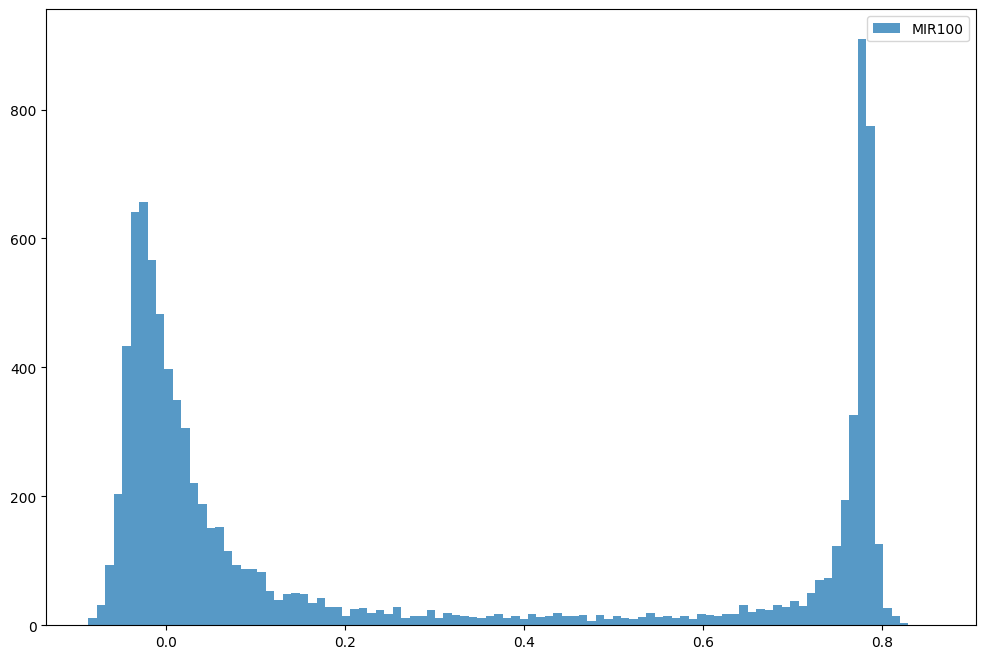

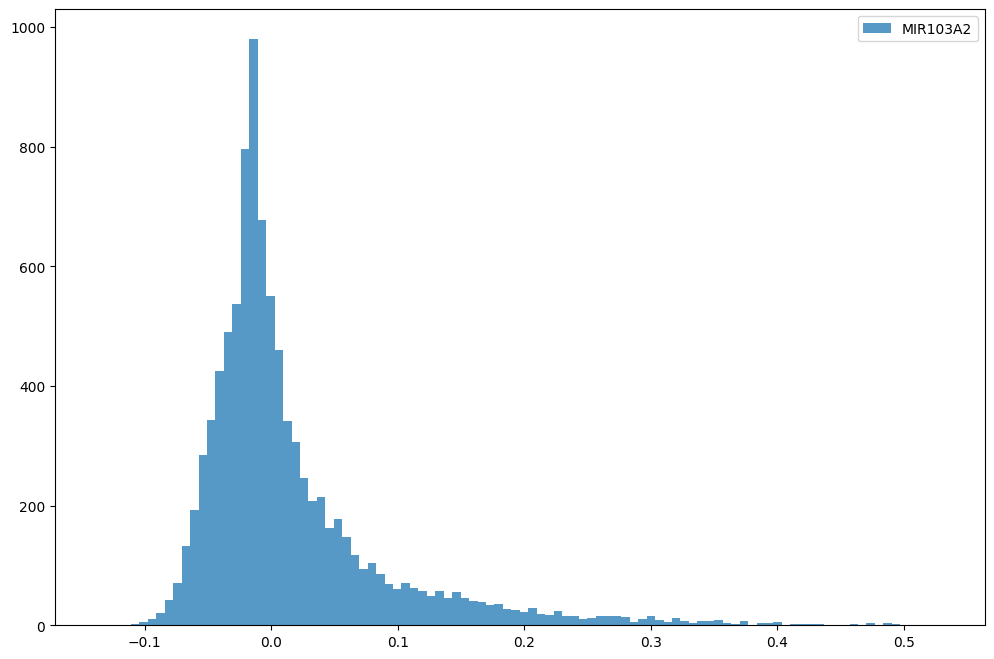

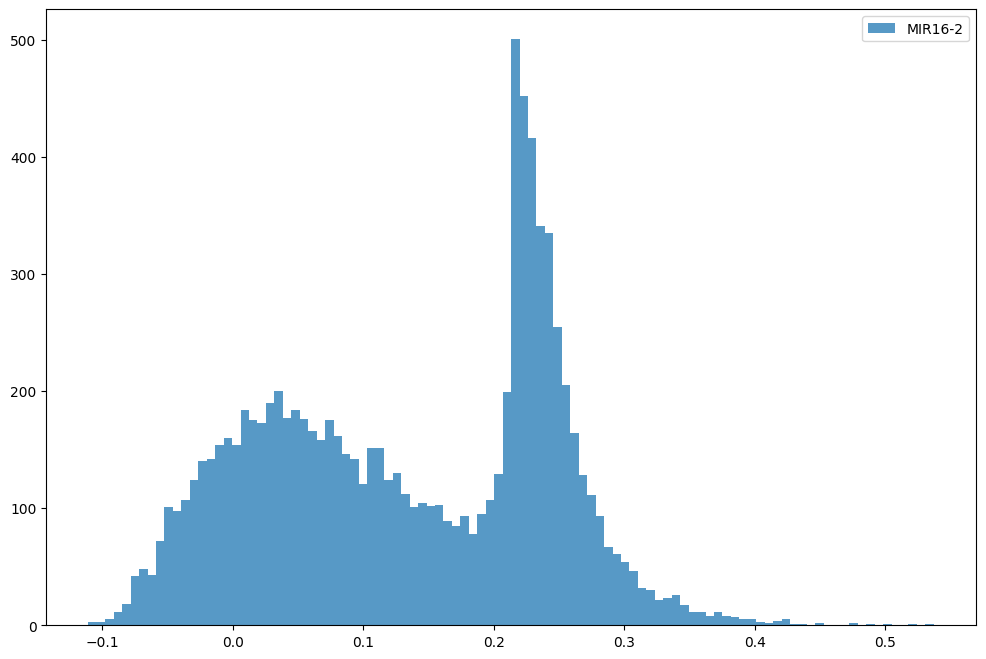

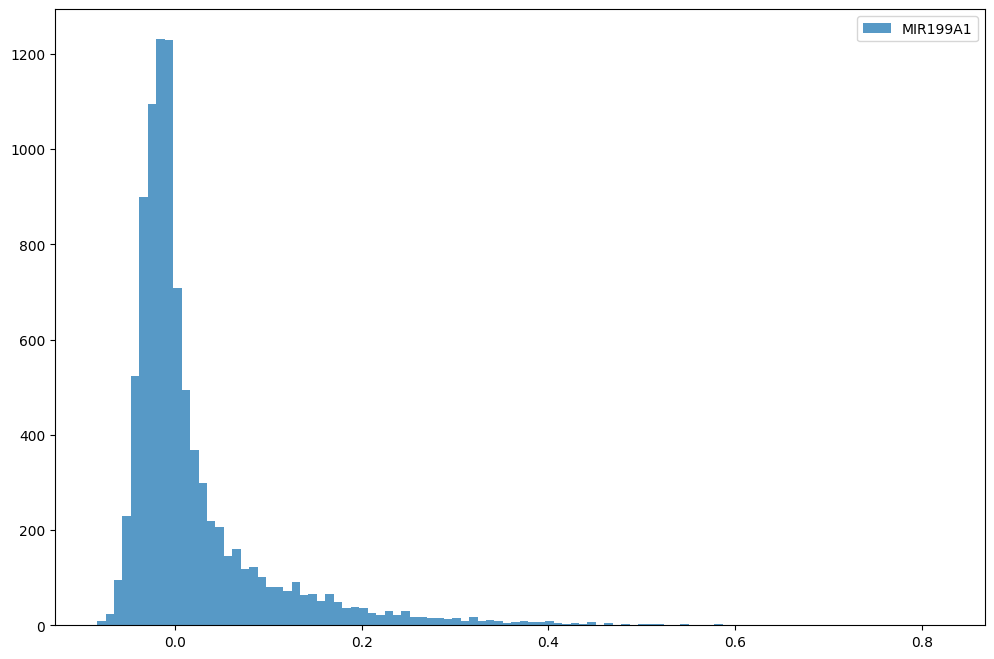

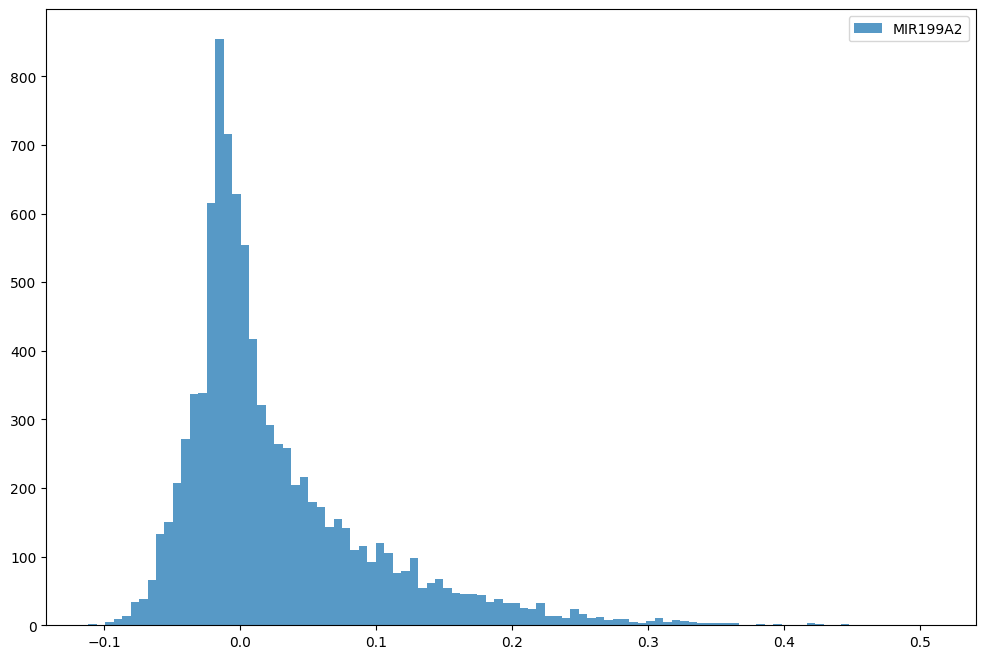

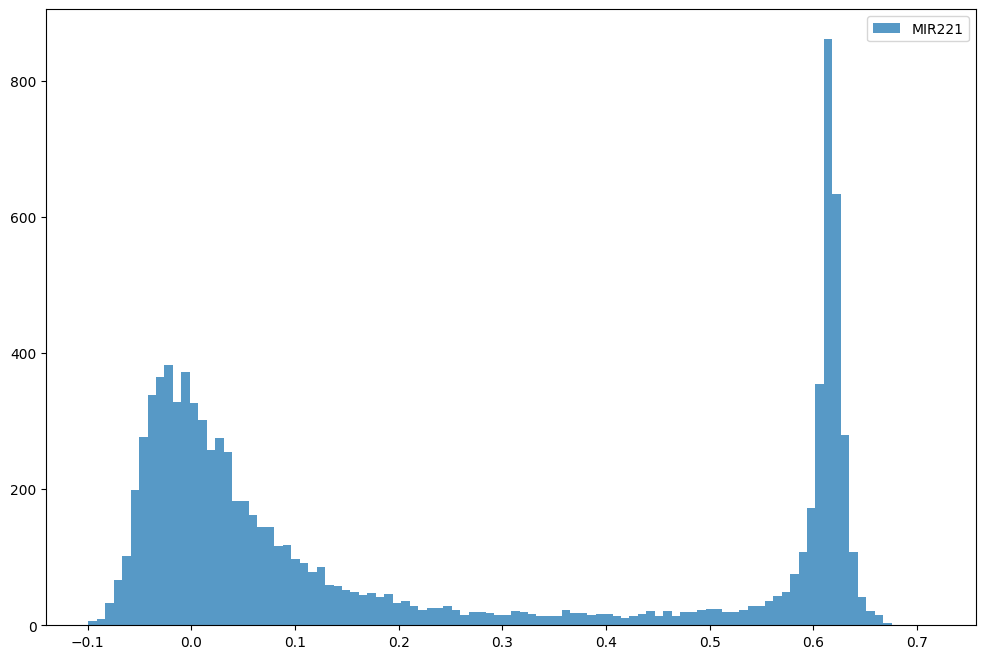

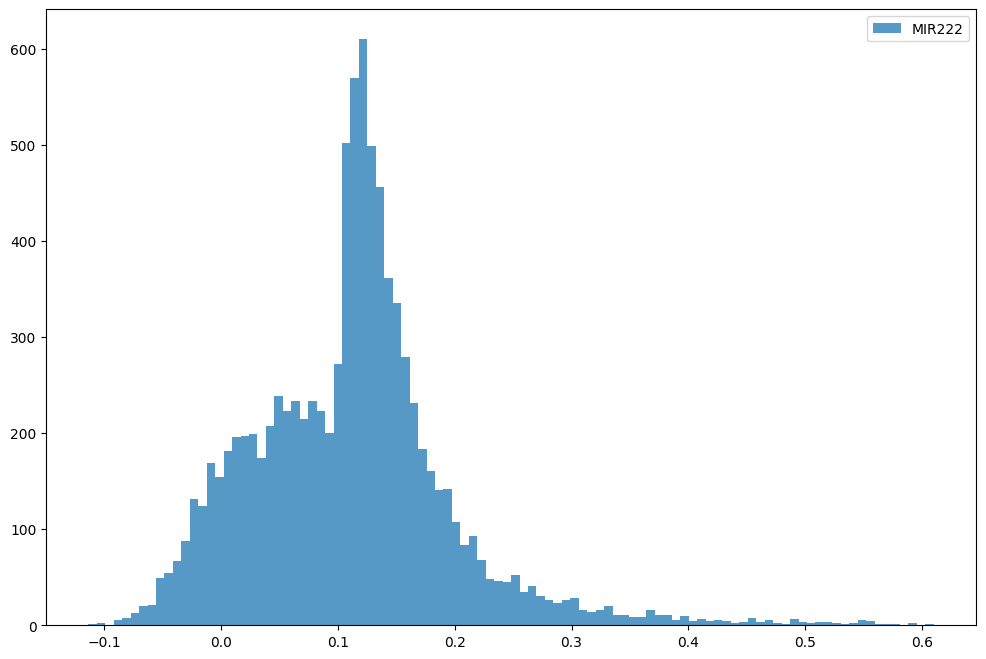

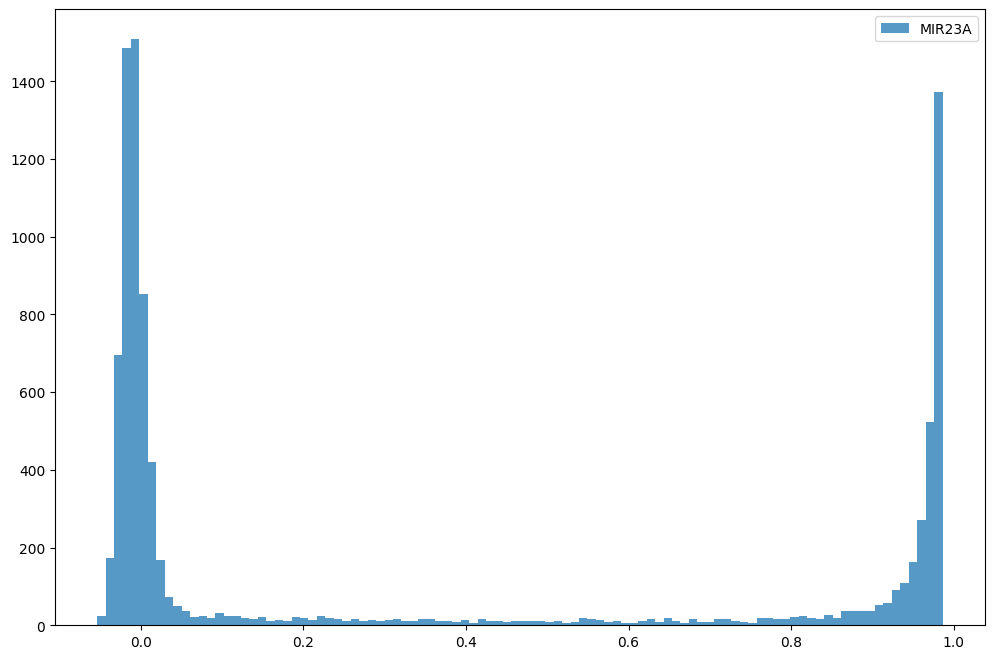

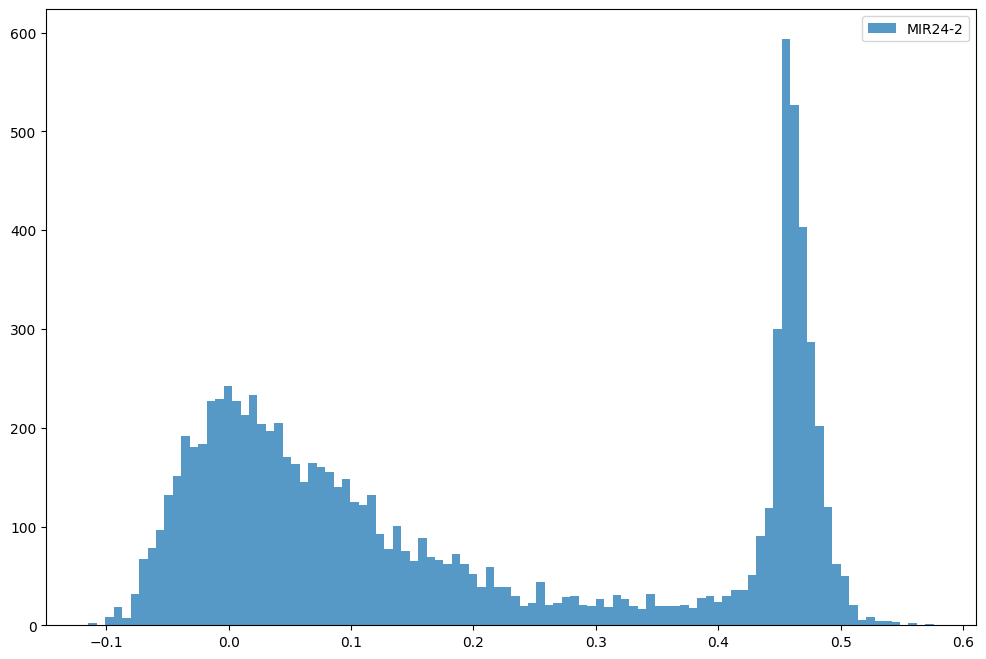

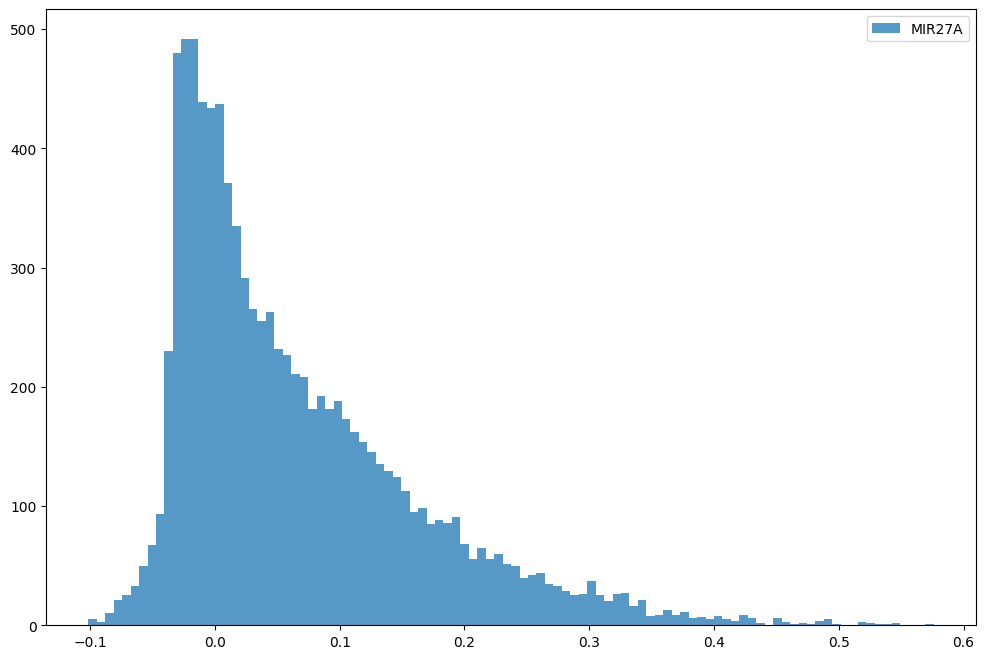

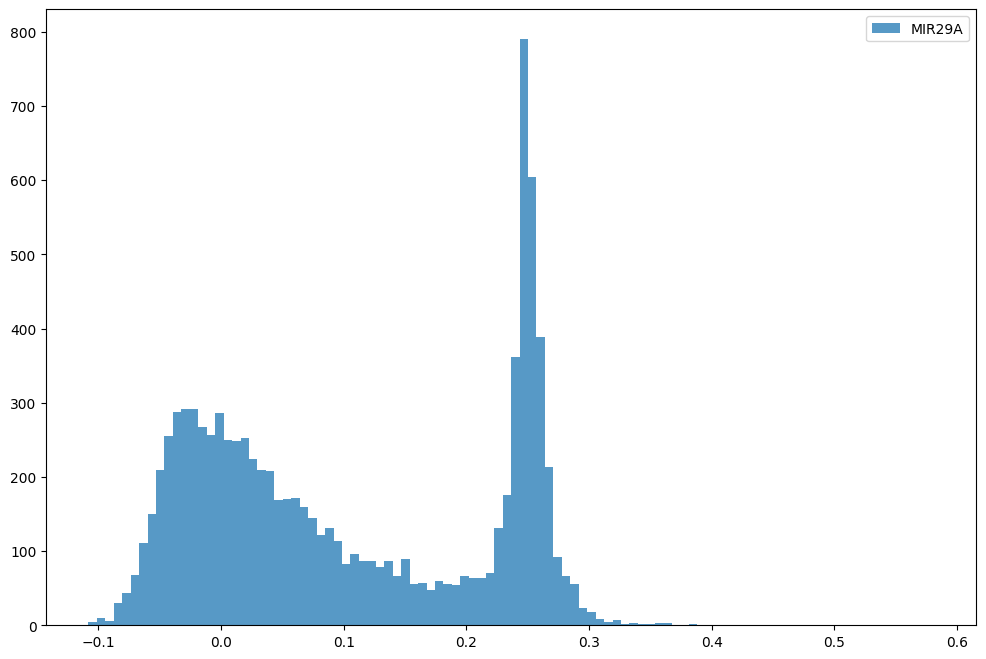

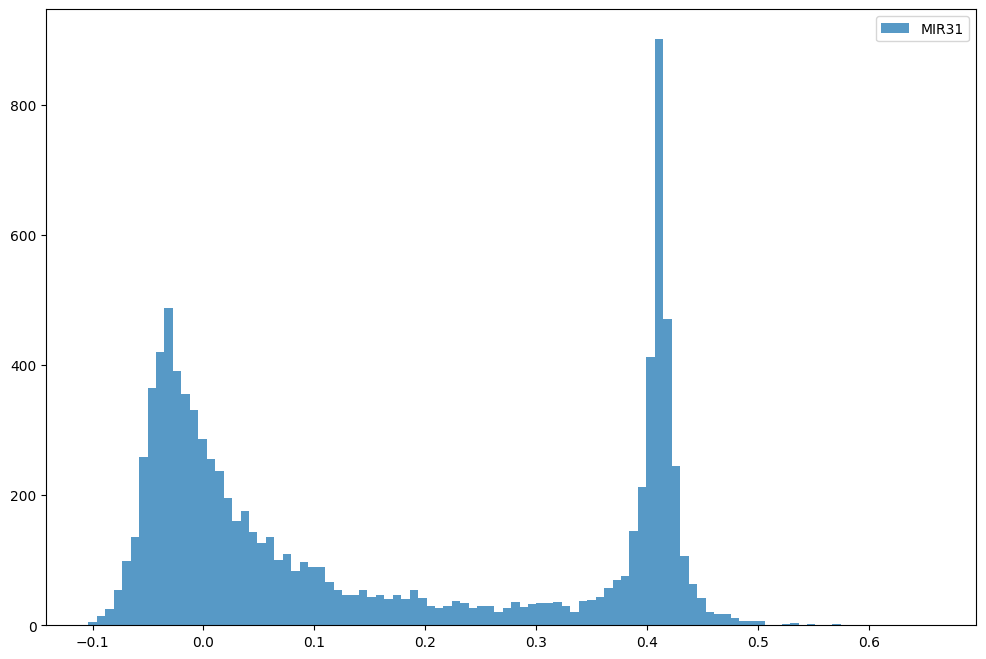

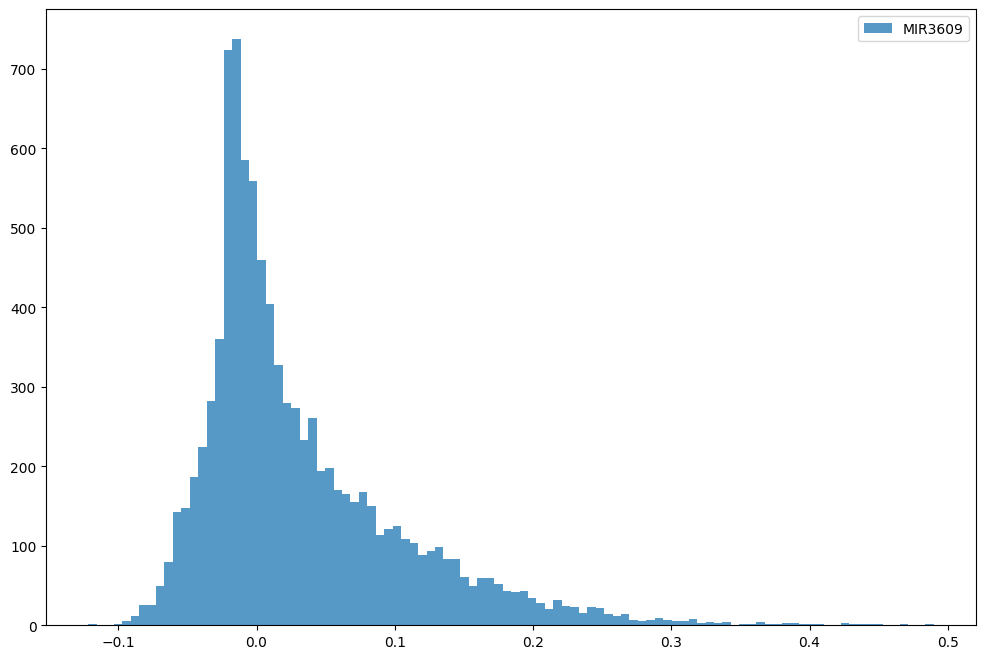

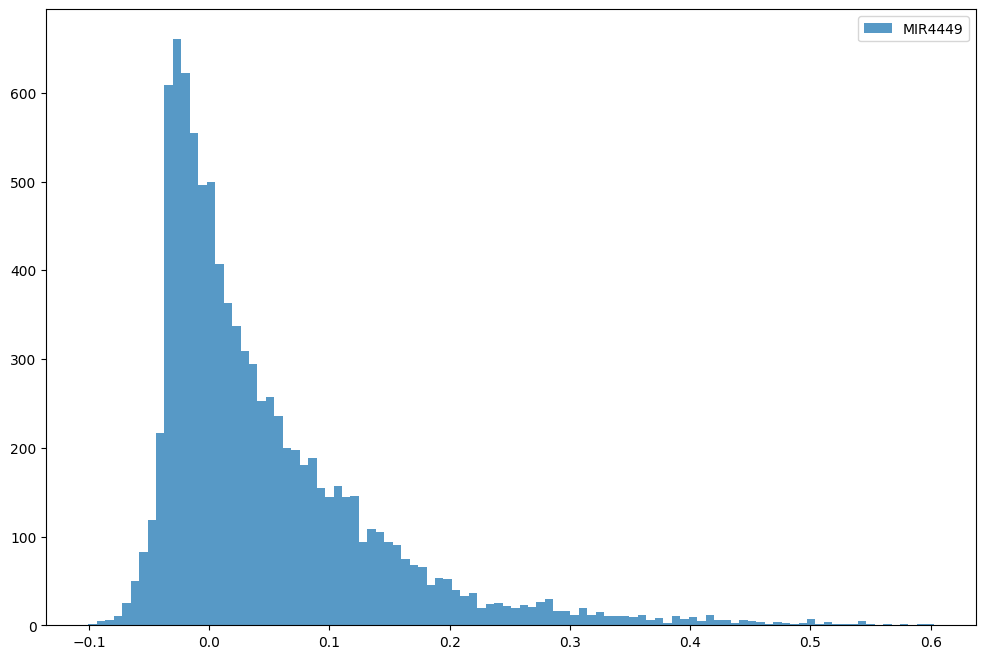

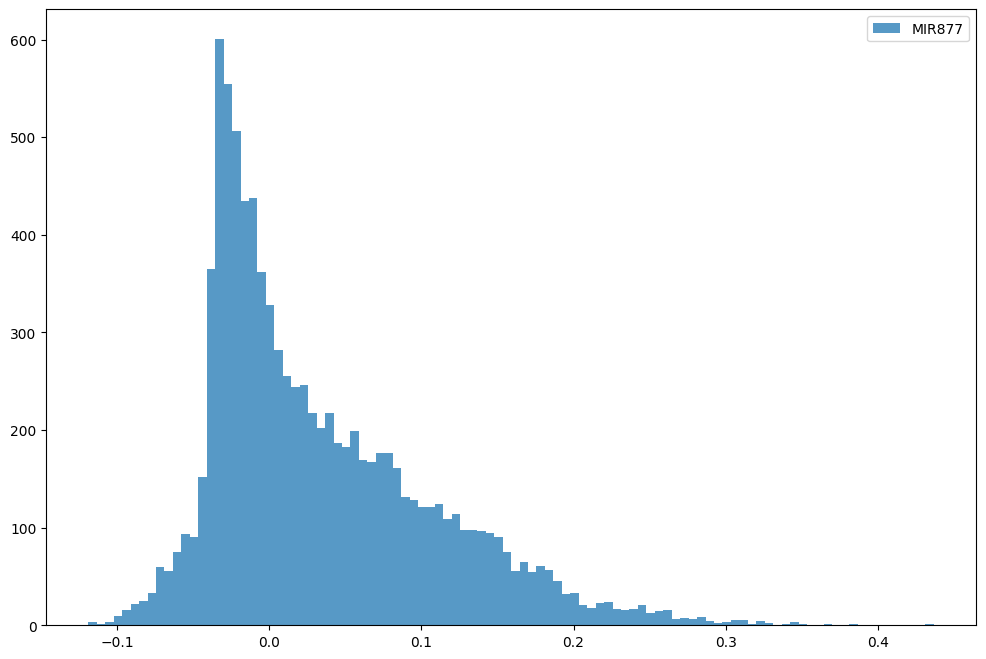

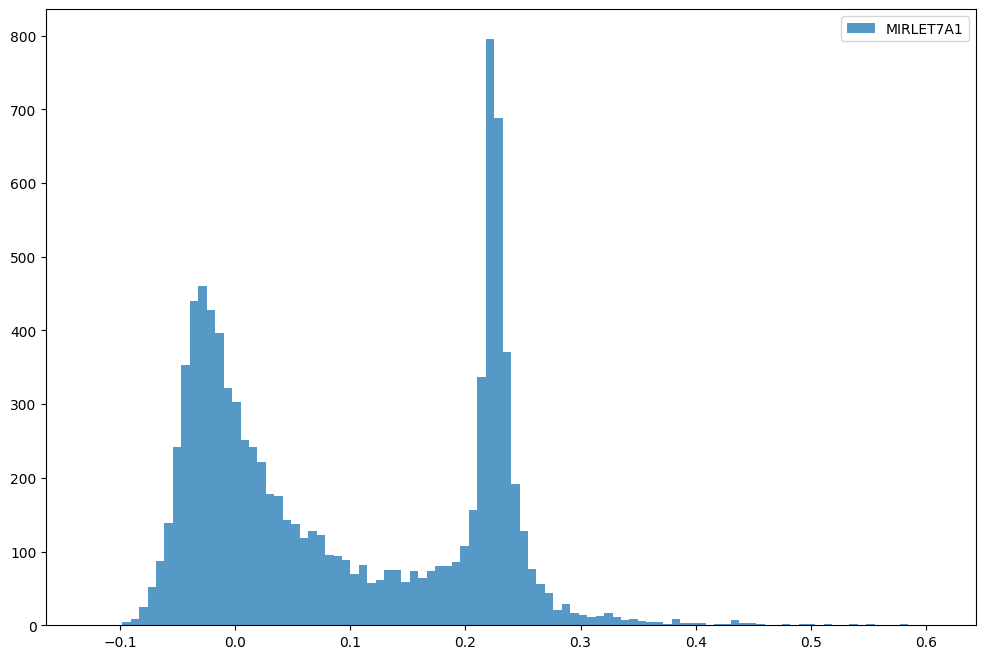

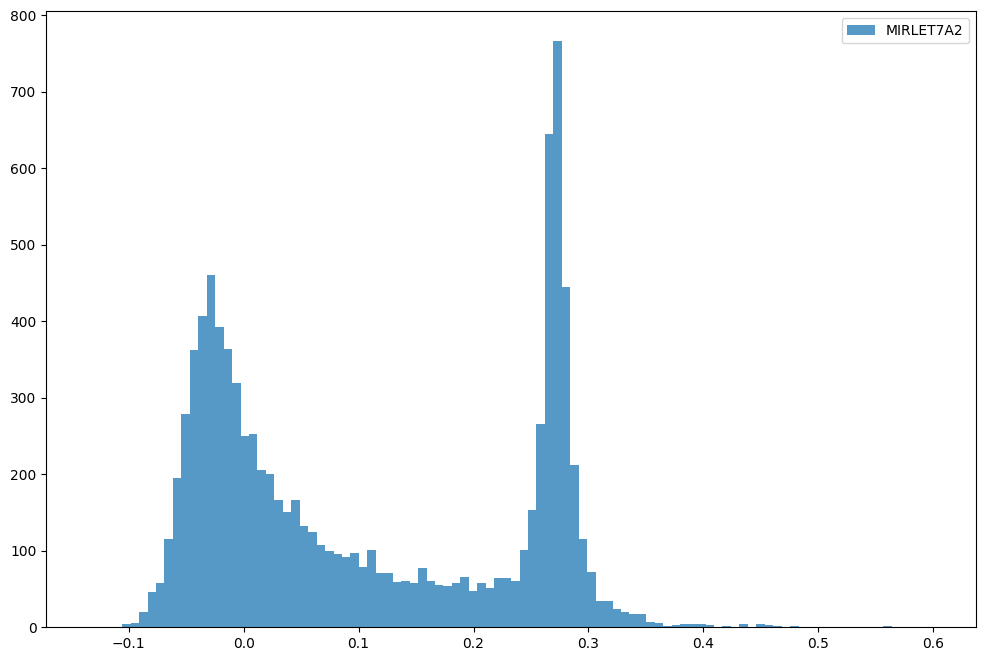

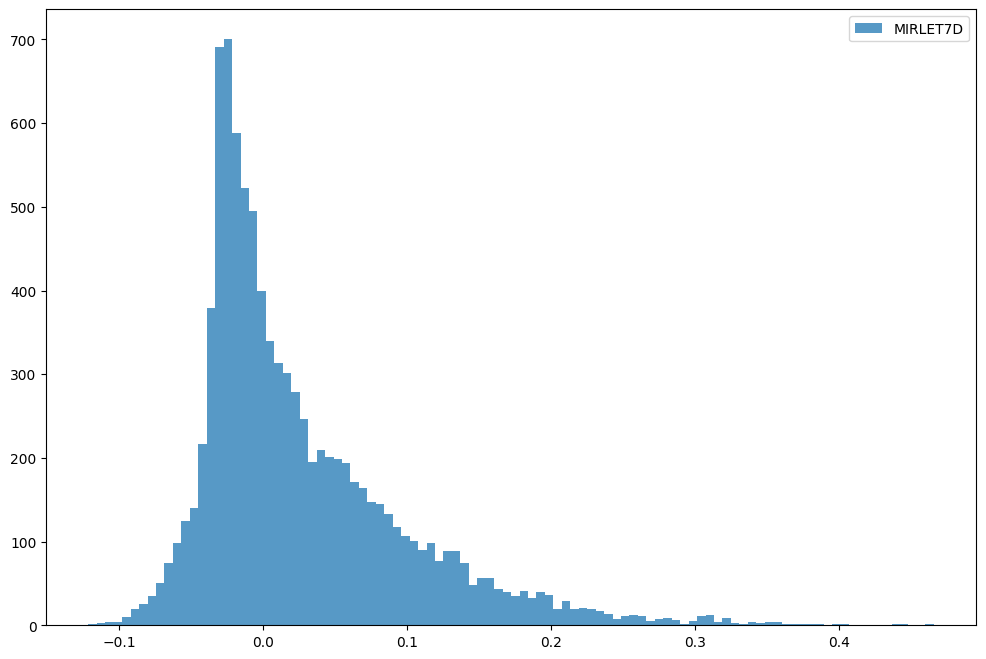

In [84]:
for j in range(len(corr_list)):
    fig = plt.figure(figsize=(12, 8))
    for i, result in enumerate(corr_list):
        if i == j:
            name = data_miRNA.index[i]
            plt.hist(result['value_summary_corr']['Statistic'].dropna(), alpha=0.75, label=name, bins=100)
    plt.legend()
    plt.show()

In [78]:
# genes
genes = 1000
k = 0

# no capture
beta = np.ones(data_pcRNA.shape[1])

# construct dataset of the miRNA paired with mRNA (NOTE: not actually using target scan targets)
dataset_mir = construct_dataset(data_miRNA.loc["MIR100"], data_pcRNA[k:k+genes], beta)

# order
d = 2

# bootstrap
dataset_mir.bootstrap(d=d, tqdm_disable=False)

# Model free test
constraints = Constraint(
    moment_bounds=True,
    moment_matrices=True,
    factorization=True
)

# test feasibility
opt_MF = optimization.ModelFreeOptimization(dataset_mir, d, constraints=constraints, printing=False, silent=True)
opt_MF.analyse_dataset()

# display
count = 0
for i, result in opt_MF.result_dict.items():
    if result['status'] == "INFEASIBLE":
        count += 1
print(f"{count} / {genes} dependent (miRNA, mRNA) pairs")

100%|██████████| 1000/1000 [00:18<00:00, 55.51it/s]

22 / 1000 dependent (miRNA, mRNA) pairs
